In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import numpy as np
import pkg_resources
from sampling import Sampler
import time

from receding_utils import create_grid_and_edges, a_star_graph, distance, create_voxsubmap
#from grid import create_grid
#from planning3D import a_star
#from planning_utils import heuristic, prune_path
#from planning_utils import a_star_graph, distance
#from voxmap import create_voxsubmap

In [2]:
plt.rcParams['figure.figsize'] = 6,6

filename = 'colliders-short.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=3)


drone_altitude = 5
#start_ne = (25,  100, drone_altitude) #NEU
start_ne = (25,  100) #NEU
#goal_ne = (750, 370, drone_altitude)
goal_ne = (750, 370)
close_goal_pt = (0,0, drone_altitude)
close_start_dist= 9999
close_goal_dist = 9999

In [3]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude) # Voronoi fix altitude
print(len(edges))

462


In [4]:
# equivalent to
# plt.imshow(np.flip(grid, 0))

G = nx.Graph()

In [5]:
def heuristic(n1, n2):
    # TODO: define a heuristic
    return distance(n1,n2)

graph digested 4.34375
Found a path.
A* graph found 4.375
path length 64


Text(0, 0.5, 'NORTH')

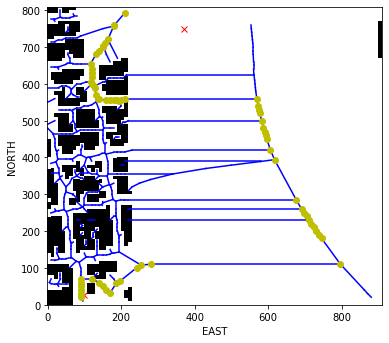

In [6]:
plt.imshow(grid, origin='lower', cmap='Greys')

import numpy.linalg as LA

for e in edges:
    p1 = (int(e[0][0]), int(e[0][1]))
    p2 = (int(e[1][0]), int(e[1][1]))
    dist = distance(p2, p1)
    G.add_edge(p1,p2,weight=dist)
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    dist_s  = distance(start_ne, p1)
    if dist_s < close_start_dist :
        close_start_dist = dist_s
        close_start_pt = p1

    dist_g  = distance(goal_ne, p1)
    if dist_g < close_goal_dist :
        close_goal_dist = dist_g
        close_goal_pt = p1
        
# time.clock은 python 3.3 이후 더이상 사용되지 않는다. 대신 time.perf_counter 또는 time.process_time 사용
print("graph digested", time.process_time())
path = a_star_graph(G, heuristic, close_start_pt, close_goal_pt)
print("A* graph found", time.process_time())
#    shortestpath = nx.dijkstra_path(G, close_start_pt, close_goal_pt, 'weight')
#    print("dijkstra graph found", time.clock())


plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.plot(close_start_pt[1], close_start_pt[0], 'yo')
plt.plot(close_goal_pt[1], close_goal_pt[0], 'yo')

# plot dijkstra path in cyan
#    for pt in shortestpath:
#        plt.plot(pt[1], pt[0], 'g^')

# plot path in yellow
for p in range(0, len(path[0]) - 1):
    pt = path[0][p].next_node()
    plt.plot(pt[1], pt[0], 'yo')

print("path length", len(path[0]))

plt.xlabel('EAST')
plt.ylabel('NORTH')

In [7]:
#--voxel code below
# close_start_pt

flight_altitude = 3
safety_distance = 3
myVoxelSize = 5

print ("start {1} and next {2}", close_start_pt, close_start_pt)

start {1} and next {2} (20, 92) (20, 92)


In [8]:
# path is the global graph solution that will lead us close to the goal

#   create a voxel map centered on current drone position (path and index)
#   identify point on graph closest to the goal within the voxel space and A* to that point

curr_position = close_start_pt
voxsubdim = (20, 20, 10)  # half dimension north, east, up
myVoxelSize = 5

In [ ]:
while curr_position != close_goal_pt :
    voxsubmap, next_position = create_voxsubmap(data, G, path, curr_position, voxsubdim)
#    sub_path, _ = a_star(voxsubmap, heuristic, curr_position, next_position)
#    pruned_path = prune_path(sub_path)
#    print(len(pruned_path))


print("Final voxmap after reaching goal")
fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.voxels(voxsubmap, edgecolor='k')
ax.set_xlim(voxsubmap.shape[0], 0)
ax.set_ylim(0, voxsubmap.shape[1])
# add 100 to the height so the buildings aren't so tall
ax.set_zlim(0, voxsubmap.shape[2])

for p in pruned_path :
    ax.scatter(p[1], p[0], p[2], 'yo')

plt.show()